# ***Install necessary libraries***
To kickstart our anomaly detection tasks, it's crucial to acquire key libraries that bring essential functionalities to our workflow:

1.**OpenL3 - Audio Embedding Framework**

  **Purpose**: OpenL3 is a powerful codebase designed for audio embedding, a crucial step in our processing pipeline. It excels in extracting high-level representations from audio signals.

  **Features**: OpenL3 provides robust feature extraction, capturing salient characteristics like timbre and rhythm. Its versatility makes it suitable for applications ranging from music analysis to sound event recognition.

2.**Librosa - Audio Signal Processing Library**

  **Purpose**: Librosa is a comprehensive library tailored for audio signal processing, offering tools for analysis and manipulation of audio signals.
  
  **Features**: Librosa supports spectral analysis, feature extraction, and visualization. It is widely used in music information retrieval and machine learning, enabling tasks such as generating spectrograms and extracting tempo and beat information.

By incorporating OpenL3 and Librosa into our toolkit, we enhance our audio processing capabilities, extracting meaningful features and insights with precision and efficiency.



In [ ]:
!pip install openl3
!pip install librosa

# **Import relevant libraries**
Let's transition to the next phase by importing pertinent libraries essential for our tasks. These libraries will facilitate operations related to the operating system, file handling, audio file manipulation, audio embedding, and classification tasks.

In [ ]:
# Import relevant libraries to work with files and with the operating system
import zipfile
import os

# Import relevant libraries for working with audio files as well as audio
# embedding
import librosa
import openl3

# Import relevant libraries for performing calculations and classification
import numpy as np
from sklearn.svm import SVC

# **Establishing a Connection Between Google Drive and Google Colab**

To streamline our workflow and seamlessly access project-related files, we'll establish a connection with Google Drive. This integration ensures a smooth collaboration between Google Drive and Google Colab, enabling efficient handling of relevant files throughout the project.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# **Extracting Data: Unzipping Audio Samples for Processing**

Our next step involves unpacking a zip file containing the crucial audio samples essential for our work. By extracting these files, we pave the way for seamless access and utilization throughout the course of our project.

In [ ]:
os.chdir('/content/drive/MyDrive/AD-Blocker Project')

# Specify the path to your zip file
zip_file_path = '/content/drive/MyDrive/AD-Blocker Project/validation.zip'

# Specify the directory where you want to extract the contents
extract_dir = '/content/drive/MyDrive/AD-Blocker Project/'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)



In [ ]:
import os
import librosa
import openl3
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'openl3'

# **Loading Audio Files**
Before processing any audio data, it's crucial to load the audio files correctly. This function, load_audio, accomplishes precisely that. It takes a file path as input and returns the audio signal along with its sample rate. Let's delve into the details of this function.

In [ ]:
def load_audio(file_path):
    """
    Load an audio file and return the audio data and sample rate.

    Parameters:
    - file_path: The path to the audio file.

    Returns:
    - audio_data: The audio signal.
    - sample_rate: The sample rate of the audio file.
    """
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    return audio_data, sample_rate

# ***Extracting Audio Embeddings***
Now that we have successfully loaded our audio data, the next step is to extract meaningful embeddings from it. This function - **"extract_audio_embedding"** employs OpenL3 to extract audio embeddings from the input audio data. Let's explore how it's done.

In [ ]:
def extract_audio_embedding(audio_data, sample_rate):
    """
    Extract audio embeddings using OpenL3.

    Parameters:
    - audio_data: The audio signal.
    - sample_rate: The sample rate of the audio file.

    Returns:
    - embedding: The audio embedding.
    """
    # Extract embeddings using OpenL3
    size = 512
    embedding, _ = openl3.get_audio_embedding(audio_data, sample_rate, content_type="music", embedding_size=size)

    # embedding, _ = openl3.get_audio_embedding(audio_data, sample_rate, content_type="music")
    flat_embedding = np.ravel(embedding)
    return flat_embedding

# ***Loading Audio Data and Labels***

Loading audio data along with their corresponding labels is a crucial step in any machine learning pipeline. This function - **"load_data"** facilitates this process by traversing through a specified folder, loading audio files, extracting embeddings, and mapping labels. Let's examine how this function operates.

In [ ]:
def load_data(data_folder):
    """
    Load audio data and corresponding labels from a folder.

    Parameters:
    - data_folder: The path to the folder containing audio files.

    Returns:
    - embeddings: List of audio embeddings.
    - labels: List of corresponding labels.
    """
    embeddings = []
    labels = []
    class_labels = {}  # Dictionary to map class names to label indices
    label_index = 0
    #number_of_samples = 0  # try with only one sample'''


    for class_name in sorted(os.listdir(data_folder)):
        class_folder = os.path.join(data_folder, class_name)
        class_labels[class_name] = label_index
        for file_name in os.listdir(class_folder):
            file_path = os.path.join(class_folder, file_name)
            #number_of_samples += 1  # try with only one sample'''
            if file_name.endswith('.wav'):  # Process only WAV audio files
                duration = librosa.get_duration(path=file_path)
                if duration < 10.0:
                  print(file_name)
                  continue
                audio_data, sample_rate = load_audio(file_path)
                embedding = extract_audio_embedding(audio_data, sample_rate)
                embeddings.append(embedding)
                # embeddings.append(embedding.flatten()) #flatten 3d matrix into 2d matrix for svc
                labels.append(label_index)
            #if number_of_samples >= 1 :  # '''try with only one sample'''
              #break     # try with only one sample

        label_index += 1

    # need to avoid the np.array that causing problems

    return np.array(embeddings), np.array(labels), class_labels

# ***Saving Embeddings to Disk***

After processing and extracting embeddings from audio data, it's essential to save these embeddings for later use.

This section demonstrates how to save the embeddings along with their corresponding labels to disk.

In [ ]:
# Path to data folders
train_data_folder = "/content/drive/MyDrive/AD-Blocker Project/train"
val_data_folder = "/content/drive/MyDrive/AD-Blocker Project/validation"
test_data_folder = "/content/drive/MyDrive/AD-Blocker Project/test"


# ***Training SVM Model***

To classify audio data accurately, we need to train a machine learning model.

This function - ***train_svm_model***, trains a Support Vector Machine (SVM) model using the provided embeddings and their corresponding labels.

Let's delve into the training process.

# ***Loading Training, Validation, and Test Data***

Before training and evaluating our machine learning model, we need to load the training, validation, and test data. This section demonstrates how to load the embeddings and their corresponding labels for each dataset.

In [ ]:
# Load training, validation, and test data

train_embeddings, train_labels, class_labels = load_data(train_data_folder)

val_embeddings, val_labels, _ = load_data(val_data_folder)

test_embeddings, test_labels, _ = load_data(test_data_folder)

# Save the embeddings to disk
# np.save("/content/train_embeddings.npy", train_embeddings)
# np.save("/content/train_labels.npy", train_labels)
# np.save("/content/val_embeddings.npy", val_embeddings)
# np.save("/content/val_labels.npy", val_labels)
# np.save("/content/test_embeddings.npy", test_embeddings)
# np.save("/content/test_labels.npy", test_labels)

3/3 [==============================] - 1s 123ms/step
ad_exit_sample22.wav
3/3 [==============================] - 1s 122ms/step
podcast_sample1264.wav
3/3 [==============================] - 1s 123ms/step


In [ ]:
train_embeddings_path = '/content/drive/MyDrive/AD-Blocker Project/embeddings/train_embeddings.npy'
np.save(train_embeddings_path, train_embeddings)

train_labels_path = '/content/drive/MyDrive/AD-Blocker Project/embeddings/train_labels.npy'
np.save(train_labels_path, train_labels)

val_embeddings_path = '/content/drive/MyDrive/AD-Blocker Project/embeddings/val_embeddings.npy'
np.save(val_embeddings_path, val_embeddings)

val_labels_path = '/content/drive/MyDrive/AD-Blocker Project/embeddings/val_labels.npy'
np.save(val_labels_path, val_labels)

test_embeddings_path = '/content/drive/MyDrive/AD-Blocker Project/embeddings/test_embeddings.npy'
np.save(test_embeddings_path, test_embeddings)

test_labels_path = '/content/drive/MyDrive/AD-Blocker Project/embeddings/test_labels.npy'
np.save(test_labels_path, test_labels)


In [ ]:
import numpy as np

def train_svm_model(embeddings, labels):
    """
    Train an SVM model using the embeddings and labels.

    Parameters:
    - embeddings: List of embeddings (list of arrays).
    - labels: List of corresponding labels.

    Returns:
    - model: Trained SVM model.
    """
    # Convert the list of arrays into a 3D NumPy array
    # embeddings_array = np.array(embeddings).flatten()

    # # Find the maximum length along the second dimension
    # max_length = np.max([embedding.shape[0] for embedding in embeddings_array])

    # Pad or truncate embeddings to have the same length
    # embeddings_padded = []
    # for embedding in embeddings_array:
    #     if embedding.shape[0] < max_length:
    #         # Pad the embedding with zeros to match the maximum length
    #         embedding_padded = np.pad(embedding, ((0, max_length - embedding.shape[0]), (0, 0)), mode='constant')
    #     elif embedding.shape[0] > max_length:
    #         # Truncate the embedding to match the maximum length
    #         embedding_padded = embedding[:max_length]
    #     else:
    #         embedding_padded = embedding  # No padding or truncation needed
    #     embeddings_padded.append(embedding_padded)

    # Stack the padded or truncated embeddings into a single 3D array
    #embeddings_stacked = np.array(embeddings_padded)
    #print("Shape of embeddings_stacked:", embeddings_stacked.shape)
    # Reshape the 3D array to a 2D array
    #embeddings_reshaped = embeddings_stacked.reshape(embeddings_stacked.shape[0], -1)

    # Train SVM model
    model = SVC(kernel='linear')
    model.fit(embeddings, labels)
    return model


# ***Training SVM Model***

Now that we've loaded our training data, let's train a Support Vector Machine (SVM) model using this data. This section demonstrates how to train the model using the training embeddings and their corresponding labels.

In [ ]:
# Train SVM model
#print(train_embeddings)
model = train_svm_model(train_embeddings, train_labels)

NameError: name 'train_svm_model' is not defined

# ***Validation Model***

After training our SVM model, it's crucial to validate its performance on unseen validation data. This section demonstrates how to validate the trained model using validation embeddings and their corresponding labels.

In [ ]:
# Validate model
val_accuracy = model.score(val_embeddings, val_labels)
print("Validation Accuracy:", val_accuracy)

NameError: name 'model' is not defined

# ***Testing Model***

After validating our SVM model, it's time to assess its performance on unseen test data. This section demonstrates how to test the trained model using test embeddings and their corresponding labels.

In [ ]:
# Test model
test_accuracy = model.score(test_embeddings, test_labels)
print("Test Accuracy:", test_accuracy)

NameError: name 'model' is not defined

# ***Predictions on Test Data***

After testing our SVM model, let's make predictions on the test data to evaluate its performance further. This section demonstrates how to generate predictions using the trained model and compare them with the true labels.

In [ ]:
# Predictions on test data
test_predictions = model.predict(test_embeddings)
print("Test Predictions:", test_predictions)

for i, (predicted_label, true_label) in enumerate(zip(test_predictions, test_labels)):
  print(f"Sample {i}: Predicted Label = {predicted_label}, True Label = {true_label}")

NameError: name 'model' is not defined

# ***Issues Encountered with the next Approach:***

---



We attempted to run the SVM model on our entire dataset, but encountered two significant challenges, which are also visible in the results below:

1. **Dimensionality Mismatch**: The function responsible for creating audio embeddings using the OpenL3 library returns a two-dimensional array for each audio sample. However, concatenating these embeddings results in a three-dimensional array. Unfortunately, the SVC model only accepts two-dimensional input arrays.

2. **Varying Embedding Lengths**: Another complication arises from the fact that the embeddings produced by the OpenL3 library may have slightly different lengths. This poses a problem for the SVC model, which requires all input data to be of the same length.

We would greatly appreciate any insights or suggestions on how to address these challenges effectively.

In [ ]:
# There is a problem in this function you can see the error in the result box

def train_svm_model(embeddings, labels):
    """
    Train an SVM model using the embeddings and labels.

    Parameters:
    - embeddings: List of embeddings.
    - labels: List of corresponding labels.

    Returns:
    - model: Trained SVM model.
    """
    model = SVC(kernel='linear')
    model.fit(embeddings, labels)
    return model

def main():
    # Path to data folders
    train_data_folder = "/content/drive/MyDrive/AD-Blocker Project/train"
    val_data_folder = "/content/drive/MyDrive/AD-Blocker Project/validation"
    test_data_folder = "/content/drive/MyDrive/AD-Blocker Project/test"

    # Load training, validation, and test data
    train_embeddings, train_labels, class_labels = load_data(train_data_folder)
    val_embeddings, val_labels, _ = load_data(val_data_folder)
    test_embeddings, test_labels, _ = load_data(test_data_folder)

    # Train SVM model
    model = train_svm_model(train_embeddings, train_labels)

    # Validate model
    val_accuracy = model.score(val_embeddings, val_labels)
    print("Validation Accuracy:", val_accuracy)

    # Test model
    test_accuracy = model.score(test_embeddings, test_labels)
    print("Test Accuracy:", test_accuracy)

    # Predictions on test data
    test_predictions = model.predict(test_embeddings)
    print("Test Predictions:", test_predictions)
    for i, (predicted_label, true_label) in enumerate(zip(test_predictions, test_labels)):
      print(f"Sample {i}: Predicted Label = {predicted_label}, True Label = {true_label}")

# Run the main function
main()


3/3 [==============================] - 1s 117ms/step


3/3 [==============================] - 0s 115ms/step


3/3 [==============================] - 1s 130ms/step


/usr/local/lib/python3.10/dist-packages/openl3/core.py:82: OpenL3Warning: Duration of provided audio is shorter than window size (1 second). Audio will be padded.
  warnings.warn('Duration of provided audio is shorter than window size (1 second). Audio will be padded.',


3/3 [==============================] - 1s 153ms/step


<ipython-input-4-7feab13d9a01>:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(embeddings), np.array(labels), class_labels


3/3 [==============================] - 1s 131ms/step


<ipython-input-4-7feab13d9a01>:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(embeddings), np.array(labels), class_labels


3/3 [==============================] - 1s 133ms/step


<ipython-input-4-7feab13d9a01>:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(embeddings), np.array(labels), class_labels


ValueError: setting an array element with a sequence.

# ***Run Knn model from here***

***First Step***: Load the embeddings that was allready extracted before using the OpenL3 model

In [ ]:
import numpy as np

train_embeddings = np.load('/content/drive/MyDrive/AD-Blocker Project/embeddings/train_embeddings.npy')
val_embeddings = np.load('/content/drive/MyDrive/AD-Blocker Project/embeddings/val_embeddings.npy')
test_embeddings = np.load('/content/drive/MyDrive/AD-Blocker Project/embeddings/test_embeddings.npy')

***Second Step***: Split the train_embeddings to the embbadings that belongs to the the real podcasts, and the embbadings that belongs to the anonalies -> aka each ausio sample that includes some part of the ad or consists only ad

In [ ]:
training_label = np.load('/content/drive/MyDrive/AD-Blocker Project/embeddings/train_labels.npy')
# for l in training_label:
#   print(l)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Split anomaly and normal embeddings
anomaly_embeddings_train = train_embeddings[:224]
anomaly_embeddings_train = np.delete(anomaly_embeddings_train, 154, axis=0)
anomaly_embeddings_train = np.delete(anomaly_embeddings_train, 166, axis=0)
anomaly_embeddings_train = np.delete(anomaly_embeddings_train, 198, axis=0)



normal_embeddings_train = train_embeddings[224:]   # Remaining elements are normal
normal_embeddings_train= np.vstack([normal_embeddings_train,train_embeddings[154]])
normal_embeddings_train= np.vstack([normal_embeddings_train,train_embeddings[166]])
normal_embeddings_train= np.vstack([normal_embeddings_train,train_embeddings[198]])

#print("Dimensions of the array normal: ", normal_embeddings_train.shape)
print(train_embeddings.shape)
print("Dimensions of the array anomaly: ", anomaly_embeddings_train.shape)


(1481, 49152)
Dimensions of the array anomaly:  (221, 49152)


In [ ]:
# """
# How to apply the model only on ads and podcasts
# """

# #print(train_embeddings.shape)
# # for l in train_labels:
# #   print(l)

# # Define the indices of the chunk to delete
# start_index = 153
# end_index = 223

# # Select rows before and after the chunk to keep
# anomaly_embeddings_train = train_embeddings[:start_index]
# normal_embeddings_train  = train_embeddings[end_index + 1:]



***Third step***: train the KNN model on the anomaly_embeddings_train and normal_embeddings_train, so we could get the mean of each one of the and use it to detemine the best trade off between the threshold and the K (number of neighbors)

In [ ]:
# Train KNN model on normal class
def train_knn_model(normal_embeddings):
    knn_model = KNeighborsClassifier(n_neighbors=11)  # Example: Use 5 neighbors

    dimensions = train_embeddings.shape
    print("Dimensions of the array: ", dimensions)
    knn_model.fit(normal_embeddings, np.zeros(len(normal_embeddings)))  # Labeling normal embeddings as 0
    return knn_model

knn_model = train_knn_model(normal_embeddings_train)

Dimensions of the array:  (1481, 49152)


In [ ]:
# Calculate mean distances for anomaly and normal embeddings
def calculate_mean_distances(knn_model, embeddings):
    distances, _ = knn_model.kneighbors(embeddings)
    mean_distances = distances.mean(axis=1)
    return mean_distances

anomaly_mean_distance = calculate_mean_distances(knn_model, anomaly_embeddings_train)
normal_mean_distance = calculate_mean_distances(knn_model, normal_embeddings_train)

# Determine threshold based on means and factors
anomaly_threshold = anomaly_mean_distance.mean() + 2 * anomaly_mean_distance.std()  # Example: 2 standard deviations from mean
normal_threshold = normal_mean_distance.mean() - 2 * normal_mean_distance.std()  # Example: 2 standard deviations from mean

print("Anomaly mean:", anomaly_threshold)
print("Normal mean:", normal_threshold)

Anomaly mean: 169.04946412108086
Normal mean: 79.86123473494719


In [ ]:
true_val_label = np.load('/content/drive/MyDrive/AD-Blocker Project/embeddings/val_labels.npy')

true_val_label[: 17] = 1
true_val_label[17:] = 0
true_val_label[12]=0
# for l in true_val_label:
#   print(l)

In [ ]:
# val_labels = np.load('/content/drive/MyDrive/AD-Blocker Project/embeddings/val_labels.npy')
# # for l in val_labels:
# #   print(l)
# start_index = 9
# end_index = 16

# # Select rows before and after the chunk to keep
# rows_to_keep_before = val_embeddings[:start_index]
# rows_to_keep_after = val_embeddings[end_index + 1:]

# # Concatenate the rows back together
# updated_val_embeddings = np.vstack((rows_to_keep_before, rows_to_keep_after))

# #slice val labels
# val_labels[:start_index]=1
# val_labels[end_index + 1:]=0
# index_before = val_labels[:start_index]
# index_after = val_labels[end_index + 1:]
# updated_val_labels = np.concatenate((index_before, index_after))

In [ ]:
true_test_label = np.load('/content/drive/MyDrive/AD-Blocker Project/embeddings/test_labels.npy')
true_test_label[: 17] = 1
true_test_label[17:] = 0
print("true test labels dim", true_test_label.shape)

true test labels dim (186,)


In [ ]:
# test_labels = np.load('/content/drive/MyDrive/AD-Blocker Project/embeddings/test_labels.npy')
# # for l in test_labels:
# #   print(l)
# start_index = 11
# end_index = 16

# # Select rows before and after the chunk to keep
# rows_to_keep_before = test_embeddings[:start_index]
# rows_to_keep_after = test_embeddings[end_index + 1:]

# # Concatenate the rows back together
# updated_test_embeddings = np.vstack((rows_to_keep_before, rows_to_keep_after))

# #slice val labels
# test_labels[:start_index]=1
# test_labels[end_index + 1:]=0
# index_before = test_labels[:start_index]
# index_after = test_labels[end_index + 1:]
# updated_test_labels = np.concatenate((index_before, index_after))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score, roc_auc_score, confusion_matrix

In [ ]:
# Validate KNN model
def validate_knn_model(knn_model, val_embeddings, anomaly_threshold, normal_threshold):
    distances, _ = knn_model.kneighbors(val_embeddings)
    mean_distances = distances.mean(axis=1)
    threshold = (anomaly_threshold + normal_threshold) / 2
    print("threshold: ", threshold)

    val_predictions = mean_distances > threshold  # Threshold based on means

    print (val_predictions.shape)
    print("val_predictions")
    print(val_predictions.astype(int))
    print("true_val_label")
    print(true_val_label)
    #val_accuracy = np.mean(val_predictions == 0)  # Accuracy for normal class

    val_accuracy = accuracy_score(true_val_label, val_predictions)
    return val_accuracy

val_accuracy = validate_knn_model(knn_model, val_embeddings, anomaly_threshold, normal_threshold)
print("Validation Accuracy:", val_accuracy)

threshold:  124.45534942801402
(160,)
val_predictions
[1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
true_val_label
[1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
Validation Accuracy: 0.9625


In [ ]:
# Test KNN model
def test_knn_model(knn_model, test_embeddings, anomaly_threshold, normal_threshold):
    distances, _ = knn_model.kneighbors(test_embeddings)
    mean_distances = distances.mean(axis=1)
    test_predictions = mean_distances > ((anomaly_threshold + normal_threshold) / 2)
    print(test_predictions.shape) # Threshold based on means
    # test_accuracy = np.mean(test_predictions == 0)  # Accuracy for normal class
    test_accuracy = accuracy_score(true_test_label, test_predictions)
    print("test_predictions")
    print(test_predictions.astype(int))
    print("true_test_label")
    print("true test labels dim", true_test_label.shape)

    print(true_test_label)
    return test_accuracy

test_accuracy = test_knn_model(knn_model, test_embeddings, anomaly_threshold, normal_threshold)
print("Test Accuracy:", test_accuracy)

(186,)
test_predictions
[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1
 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0
 0]
true_test_label
true test labels dim (186,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
Test Accuracy: 0.7311827956989247


In [ ]:
def predict_knn(knn_model, test_embeddings, anomaly_threshold, normal_threshold):
    distances, _ = knn_model.kneighbors(test_embeddings)
    print("dimensions of test embeddings\n", test_embeddings.shape )

    mean_distances = distances.mean(axis=1)
    print("dimensions of test distance", mean_distances.shape )
    test_predictions = mean_distances > ((anomaly_threshold + normal_threshold) / 2)
    print("true test labels dim", true_test_label.shape)
    return test_predictions.astype(int)
#test_pred = predict_knn(knn_model, test_embeddings, anomaly_threshold, normal_threshold)


dimensions of test embeddings
 (186, 49152)
dimensions of test distance (186,)
true test labels dim (186,)
predictions
(186,)
[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1
 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0
 0]
true_test_label
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
(186,)
Accuracy: 0.7311827956989247
Precision: 0.24615384615384617
Recall (Sensitivity): 0.941176470

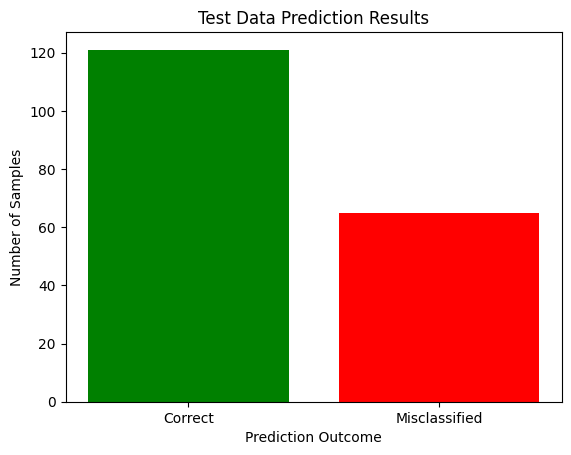

Success Percentage: 65.05376344086021 %


In [ ]:
import matplotlib.pyplot as plt

# Assuming you have predictions and true labels
predictions = predict_knn(knn_model, test_embeddings, anomaly_threshold, normal_threshold)
#predictions = knn_model.predict(test_embeddings[17:])
#true_test_label = np.array([0] * len(test_embeddings[17:]))  # Assuming all normal samples

# 1. Accuracy
print("predictions")
print(predictions.shape)
print(predictions)
print("true_test_label")
print(true_test_label)
print(true_test_label.shape)

accuracy = accuracy_score(true_test_label, predictions)
print("Accuracy:", accuracy)

# 2. Precision
precision = precision_score(true_test_label, predictions)
print("Precision:", precision)

# 3. Recall (Sensitivity)
recall = recall_score(true_test_label, predictions)
print("Recall (Sensitivity):", recall)

# 4. F1 Score
f1 = f1_score(true_test_label, predictions)
print("F1 Score:", f1)

# 5. Specificity (Inverse of False Positive Rate)
specificity = recall_score(true_test_label, predictions, pos_label=0)
print("Specificity:", specificity)

# 6. ROC AUC Score
 #roc_auc = roc_auc_score(true_test_label, predictions)
 #print("ROC AUC Score:", roc_auc)

# 7. average_precision_score
pc_auc = average_precision_score(true_test_label, predictions)
print("ROC AUC Score:", pc_auc)

# 8. Confusion Matrix
conf_matrix = confusion_matrix(true_test_label, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate number of correctly classified and misclassified samples
correct_count = np.sum(predictions == 0)  # Count of correct predictions
misclassified_count = np.sum(predictions != 0)  # Count of misclassified predictions

# Calculate success percentage
success_percentage = (correct_count / len(predictions)) * 100

# Plotting
labels = ['Correct', 'Misclassified']
counts = [correct_count, misclassified_count]

plt.bar(labels, counts, color=['green', 'red'])
plt.xlabel('Prediction Outcome')
plt.ylabel('Number of Samples')
plt.title('Test Data Prediction Results')
plt.show()

print("Success Percentage:", success_percentage, "%")

# ***non relevant code***

In [ ]:

# Path to data folders


# Load existing embeddings
# train_embeddings = np.load("train_embeddings.npy")
# val_embeddings = np.load("val_embeddings.npy")
# test_embeddings = np.load("test_embeddings.npy")

# Load training, validation, and test data for anomalies ("ads", "ad_entrance", "ad_exit")
anomaly_embeddings_ = train_embeddings[:224]

# Train KNN model on normal class
knn_model = train_knn_model(train_embeddings)

# Validate KNN model
distances, _ = knn_model.kneighbors(val_embeddings[:17])
anomaly_scores = distances.mean(axis=1)  # Using mean distance as anomaly score
val_predictions = anomaly_scores > anomaly_scores.mean() + 2 * anomaly_scores.std()  # Threshold for anomaly detection
val_accuracy = np.mean(val_predictions == 0)  # Accuracy for normal class
print("Validation Accuracy:", val_accuracy)

# Test KNN model
distances, _ = knn_model.kneighbors(test_embeddings[:17])
anomaly_scores = distances.mean(axis=1)  # Using mean distance as anomaly score
test_predictions = anomaly_scores > anomaly_scores.mean() + 2 * anomaly_scores.std()  # Threshold for anomaly detection
test_accuracy = np.mean(test_predictions == 0)  # Accuracy for normal class
print("Test Accuracy:", test_accuracy)

# Predictions on test data
print("Test Predictions (Anomaly Scores):", anomaly_scores)

# Run the main function


NameError: name 'train_knn_model' is not defined